<a href="https://colab.research.google.com/github/viniciusbedeschi/TCC/blob/main/TCC_Rede_Neural_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import zscore

#Conectando o notebook com o Drive
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import auth
import gspread

#Importando as bibliotecas do Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, LearningRateScheduler

print(tf.__version__)

Mounted at /content/gdrive
2.12.0


#Impotando a Base de Dados

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Base de dados/Base_Tratada_Selecionada_lof.csv')
display(df)

,tempo_entrega_days_real,order_item_id,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Distance,January,...,October,November,December,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,4.179016,1.0,116.9,18.92,400.0,19.0,13.0,19.0,400.466657,0,...,0,0,0,0,0,0,1,0,0,0
1,1.134433,1.0,118.7,9.34,400.0,19.0,13.0,19.0,15.654501,0,...,0,0,0,0,0,1,0,0,0,0
2,0.993021,1.0,116.9,9.33,400.0,19.0,13.0,19.0,19.466840,0,...,0,0,0,0,1,0,0,0,0,0
3,3.067801,1.0,118.7,15.93,400.0,19.0,13.0,19.0,523.062446,0,...,0,0,0,0,0,0,0,1,0,0
4,2.208646,1.0,116.9,18.92,400.0,19.0,13.0,19.0,400.466657,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,3.155903,1.0,99.0,22.51,5750.0,30.0,30.0,30.0,183.018773,0,...,0,0,0,0,0,0,0,0,0,1
6102,4.297674,1.0,57.2,12.84,150.0,22.0,3.0,15.0,134.240374,0,...,0,0,0,0,0,0,0,1,0,0
6103,7.328889,1.0,159.9,13.78,245.0,26.0,8.0,17.0,339.125166,0,...,0,0,0,1,0,0,0,0,0,0
6104,11.355266,1.0,129.9,13.35,150.0,16.0,11.0,11.0,123.276953,0,...,0,0,0,0,0,0,1,0,0,0


In [4]:
df.isna().sum()

tempo_entrega_days_real    0
order_item_id              0
price                      0
freight_value              0
product_weight_g           0
product_length_cm          0
product_height_cm          0
product_width_cm           0
Distance                   0
January                    0
February                   0
March                      0
April                      0
May                        0
June                       0
July                       0
August                     0
September                  0
October                    0
November                   0
December                   0
Monday                     0
Tuesday                    0
Wednesday                  0
Thursday                   0
Friday                     0
Saturday                   0
Sunday                     0
dtype: int64

#Implementando o Keras

Dividindo Daddos de treino e coluna alvo

In [5]:
df_treino = df[['price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'Distance', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
df_alvo = df[['tempo_entrega_days_real']]

Normalizando os dados (aplicando o Min-Max)




In [6]:
scaler = MinMaxScaler()
df_treino_norm = pd.DataFrame(scaler.fit_transform(df_treino), columns=df_treino.columns)

In [7]:
df_treino_norm

,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Distance,January,February,March,...,October,November,December,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.068339,0.132781,0.028470,0.085106,0.106796,0.141176,0.391954,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.069399,0.065548,0.028470,0.085106,0.106796,0.141176,0.015322,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.068339,0.065478,0.028470,0.085106,0.106796,0.141176,0.019053,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.069399,0.111797,0.028470,0.085106,0.106796,0.141176,0.511944,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.068339,0.132781,0.028470,0.085106,0.106796,0.141176,0.391954,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,0.057798,0.157976,0.409253,0.202128,0.271845,0.270588,0.179128,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6102,0.033183,0.090112,0.010676,0.117021,0.009709,0.094118,0.131387,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6103,0.093661,0.096709,0.017438,0.159574,0.058252,0.117647,0.331916,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6104,0.075994,0.093691,0.010676,0.053191,0.087379,0.047059,0.120656,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Criando Funções Auxiliares

In [8]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [9]:
def plot_history(history, fold):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MGP]')
  plt.plot( hist['epoch'],hist['mae'],
      label='Train Error')
  plt.plot( hist['epoch'],hist['val_mae'],
      label='Val Error')
  plt.legend()
  plt.ylim([0,5])
  plt.title('Fold {}: Gráfico de erro médio absoluto'.format(fold))

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Sqr Error [$MGP^2$]')
  plt.plot( hist['epoch'],hist['mse'],
      label='Train Error')
  plt.plot( hist['epoch'],hist['val_mse'],
      label='Val Error')
  plt.legend()
  plt.ylim([0,40])
  plt.title('Fold {}: Gráfico de erro Quadrático Médio absoluto'.format(fold))


In [10]:
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr/2

Construindo o Modelo

Treinamento do Modelo

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)


Fold:0

............................................................................MSE: 18.622406005859375, MAE: 2.474754810333252

Fold:1

....................................................................MSE: 25.10015106201172, MAE: 2.75685715675354

Fold:2

..................................................................................MSE: 19.36983299255371, MAE: 2.680805206298828

Fold:3

............................................................................MSE: 18.521291732788086, MAE: 2.650869607925415

Fold:4

........................................................................MSE: 26.378904342651367, MAE: 2.8139257431030273

Fold:5

.........................................................................MSE: 17.237167358398438, MAE: 2.5053343772888184

Fold:6

.......................................................................MSE: 11.137433052062988, MAE: 2.283231496810913

Fold:7

............................................................MSE: 17.5845775

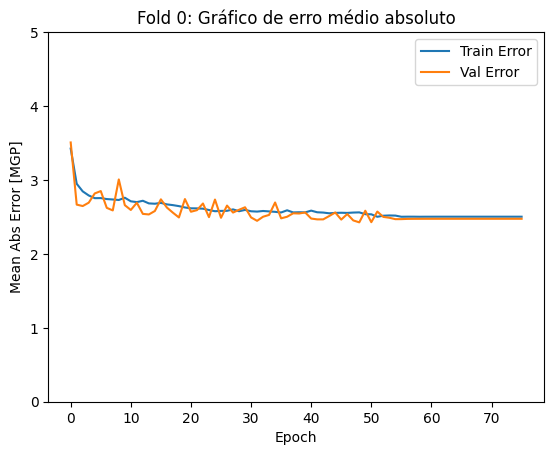

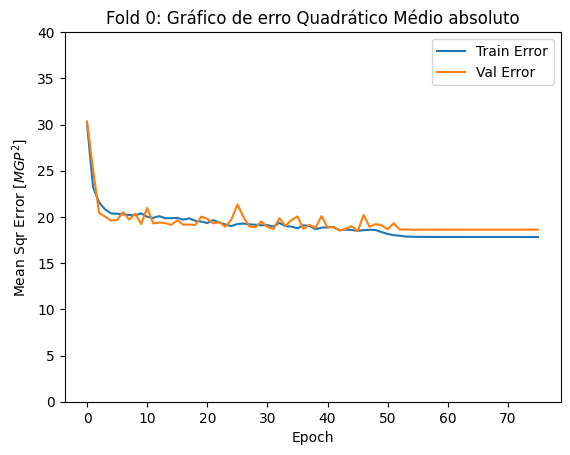

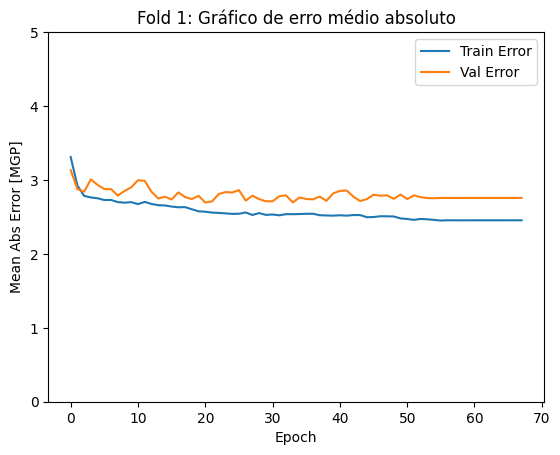

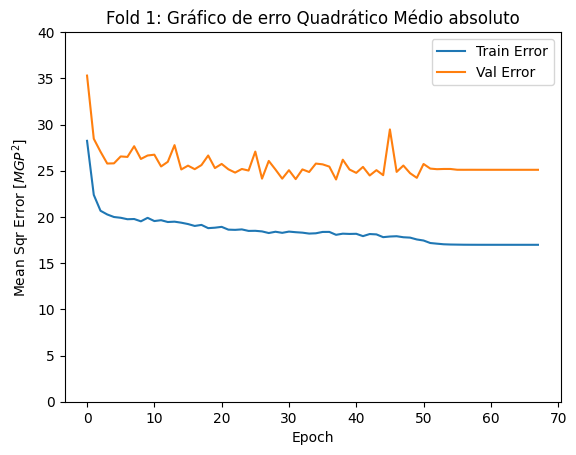

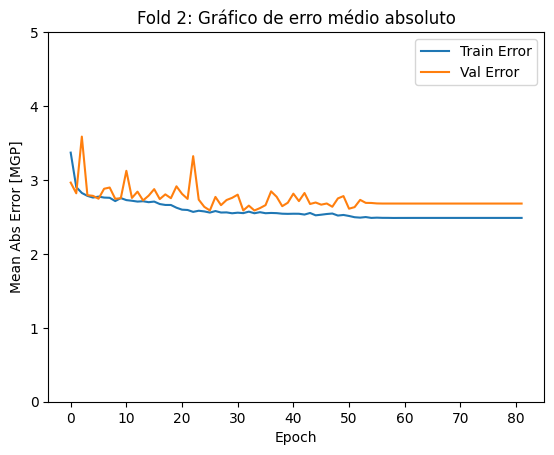

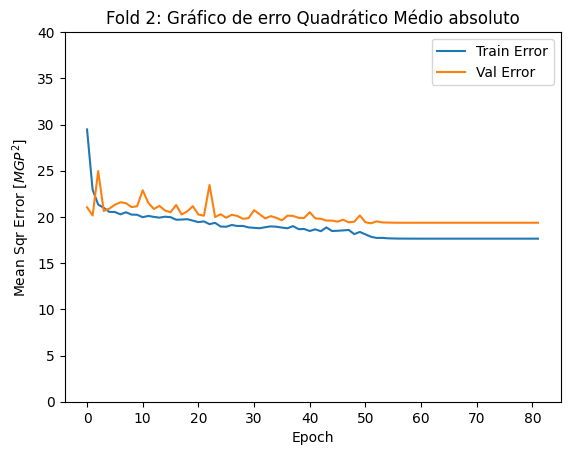

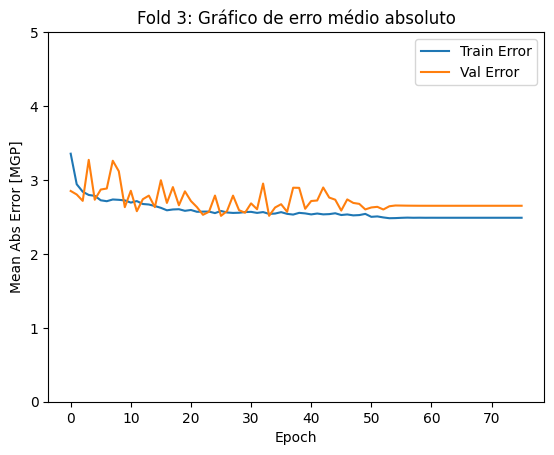

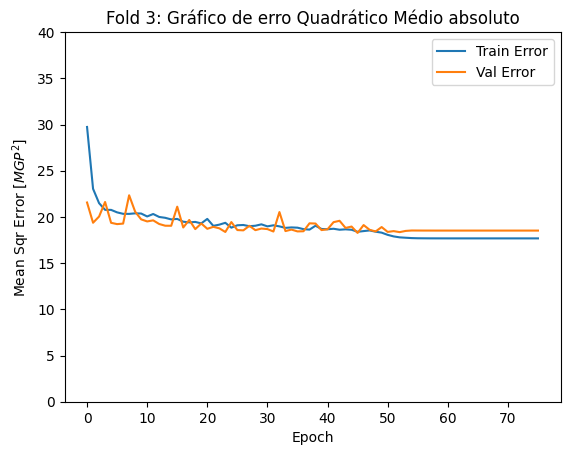

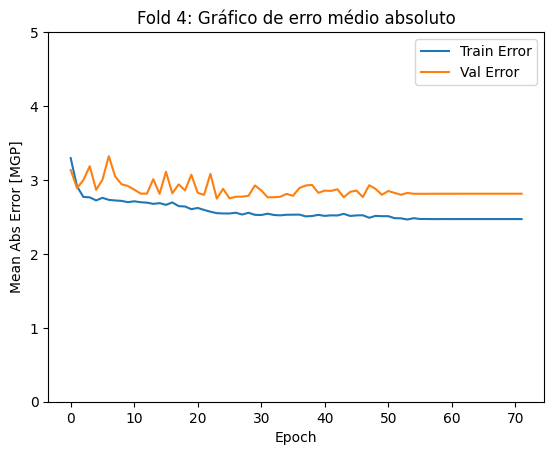

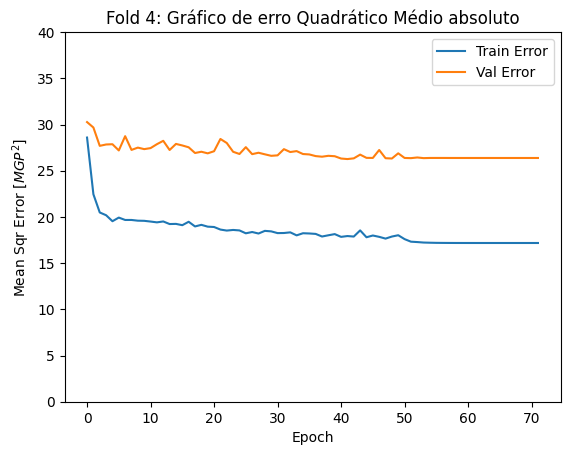

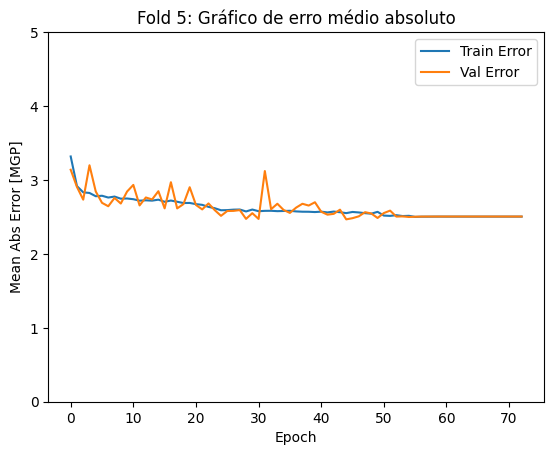

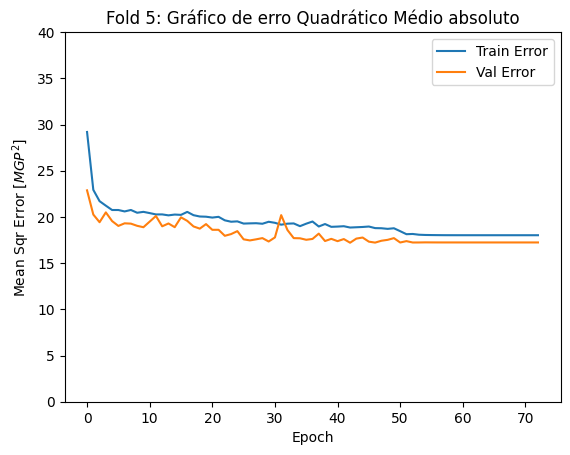

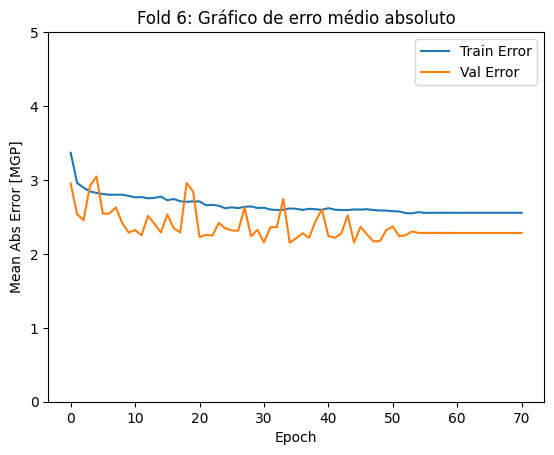

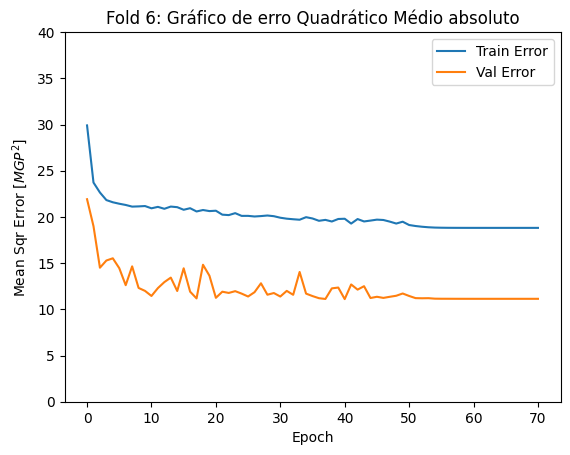

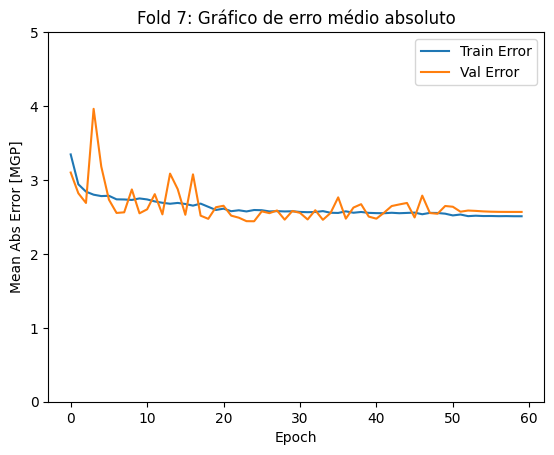

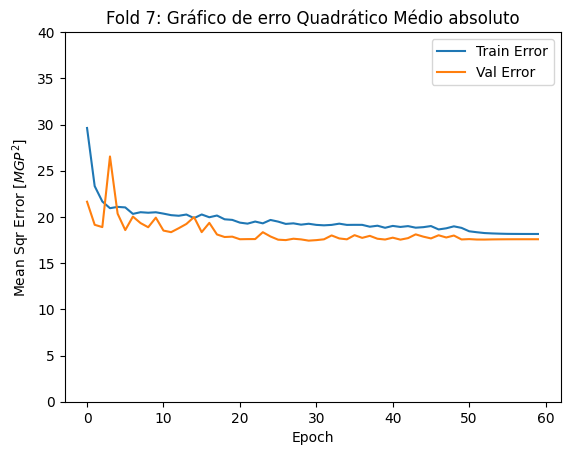

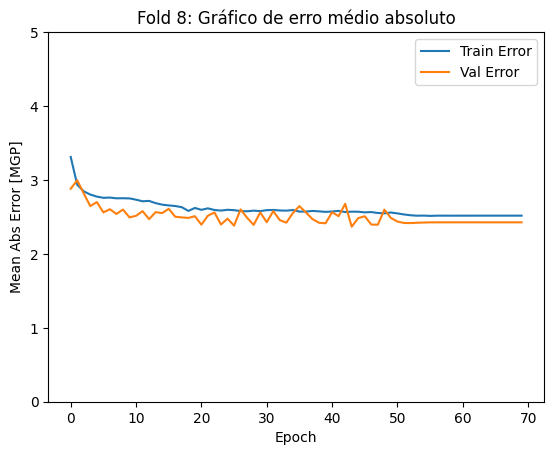

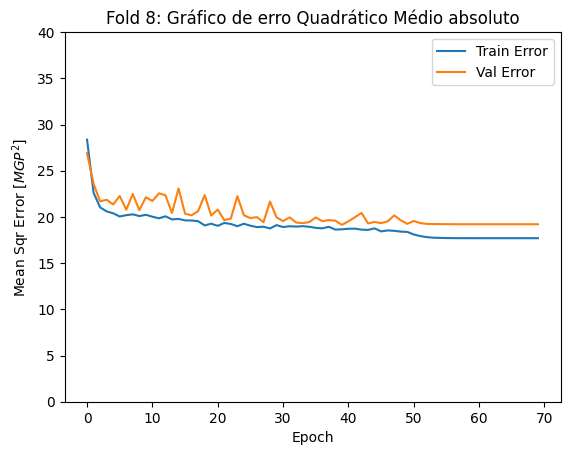

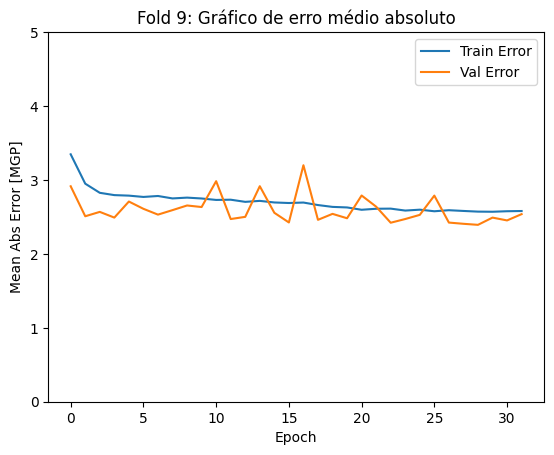

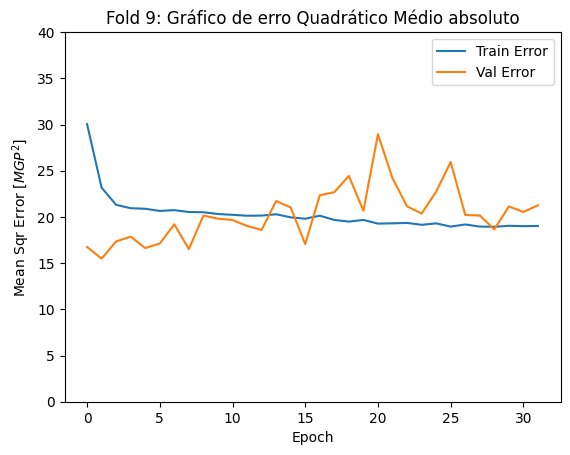

In [14]:
scores_mse = []
scores_mae = []
scores_R2 = []
fold = 0

for train, test in kfold.split(df_treino_norm):
  X_train, X_test = df_treino_norm.iloc[train], df_treino_norm.iloc[test]
  y_train, y_test = df_alvo.iloc[train], df_alvo.iloc[test]

  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  lr_scheduler = LearningRateScheduler(scheduler)

  model = keras.Sequential([
      keras.layers.Dense(32, activation='softplus', input_shape=[len(df_treino.keys())]),
      keras.layers.Dense(64, activation='softplus'),
      keras.layers.Dense(128, activation='softplus'),
      keras.layers.Dense(64, activation='softplus'),
      keras.layers.Dense(32, activation='softplus'),
      keras.layers.Dense(1)

  ])

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

  print('\nFold:' +  str(fold))

  history = model.fit(
        X_train,
        y_train,
        epochs = 1000,
        batch_size=8,
        verbose = 0,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, PrintDot(), lr_scheduler]
  )

  score = model.evaluate(X_test, y_test, verbose=0)
  print('MSE: {}, MAE: {}'.format(score[0], score[1]))
  scores_mse.append(score[0])
  scores_mae.append(score[1])
  scores_R2.append(score[2])
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  #display(hist)
  plot_history(history, fold)
  fold += 1
print('\nRede Neural:')
print('\nAcurácia média (mse):', np.mean(scores_mse))
print('\nAcurácia média (mae):', np.mean(scores_mae))

In [ ]:
print(history.history)